# Ames mutagenicity data set classification
[Ames mutagenicity data set](http://pubs.acs.org/doi/suppl/10.1021/ci900161g) is a popular dataset for benchmarking classification machine learning methods in cheminformatics. Morgan fingerprints will be used to featurize the molecules. Features will be then used to train random forest models which will be validated within 4-fold cross validation.

@TAGS: #advanced #sklearn #Classification #RandomForest

In [1]:
from __future__ import print_function
% matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

Load the pre-processed [Ames mutagenicity data set](http://pubs.acs.org/doi/suppl/10.1021/ci900161g)

In [3]:
df = PandasTools.LoadSDF('../data/ames.sdf')

,ID,ROMol,class
0,2475-33-4,,0

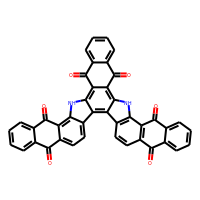

In [4]:
df.head(1)

In [5]:
len(df)

6506

## Featurization

Helper classes and functions

In [6]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circural (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn
    
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    
    if counts is True:
        info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures, bitInfo=info)
        DataStructs.ConvertToNumpyArray(fp, arr)
        arr = np.array([len(info[x]) if x in info else 0 for x in range(nBits)], dtype)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

Calculate Morgan fingerprints and store them as FP objects in the data frame

,ID,ROMol,class,FP
0,2475-33-4,,0,1024 bit FP

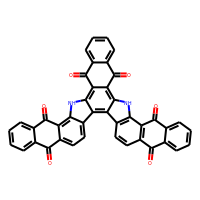

In [7]:
df['FP'] = df['ROMol'].map(get_cfps)
df.head(1)

Extract the features (X) and target values (y) from the data frame

In [8]:
X = np.array([x.fp for x in df['FP']])
y = np.array(df['class'], int)

## Cross validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

To validate a machine learning approach cross validation (CV) is common strategy since all available data is used to obtain performance metrics of your selected method. It is a good practice to keep class ratios (stratification) and shuffle samples so we will use [stratified K-fold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) CV with shuffling.

In [10]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

Random forest classifier with 10 estimators is the selected machine learning method

In [11]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)

4-fold CV

In [12]:
#doctest: IGNORE
y_values = []
predictions = []
probas = []
for train, test in kf.split(X, y):
    clf.fit(X[train], y[train])
    predictions.append(clf.predict(X[test]))
    probas.append(clf.predict_proba(X[test]).T[1]) # Probabilities for class 1
    y_values.append(y[test])

Check the performance of the models using receiver operating characteristic (ROC) curve and area under ROC curve (ROC AUC).

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [14]:
aucs = [roc_auc_score(y, proba) for y, proba in zip(y_values, probas)]

## Performance metrics

ROC AUC gives an indication how well the probabilities of the two classes are separated. Range for the ROC AUC is between 0 and 1 where 0.5 represents random selection and 1 means perfect separation.

In [15]:
print('Mean AUC: %0.2f +- %0.2f' % (np.mean(aucs), np.std(aucs)))

Mean AUC: 0.84 +- 0.01


Plot the ROC curves

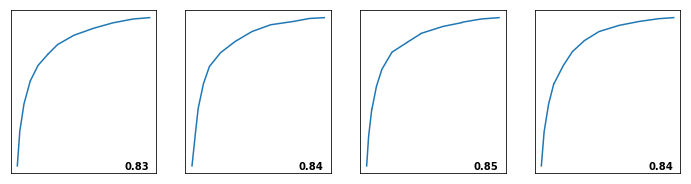

In [16]:
#doctest: IGNORE
f, ((p1, p2, p3, p4)) = plt.subplots(1,4, squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(12,3))

for y,proba,ax in zip(y_values, probas, (p1,p2,p3,p4)):
    tpr, fpr, _ = roc_curve(y, proba)
    auc = roc_auc_score(y, proba)
    ax.plot(tpr, fpr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%0.2f" % auc,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)

The four models from cross validation show very similar performance and thus it seems that our methods is robust. Final model for prospective predictions should be trained on all samples.

Tutorial author: Samo Turk, Nov. 2017